In [5]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

In [83]:
from sklearn.utils import all_estimators

In [51]:
import os
from IPython.display import clear_output

In [6]:
audio_path = 'moonlight.wav'

In [8]:
librosa_audio, librosa_sample_rate = librosa.load(audio_path)

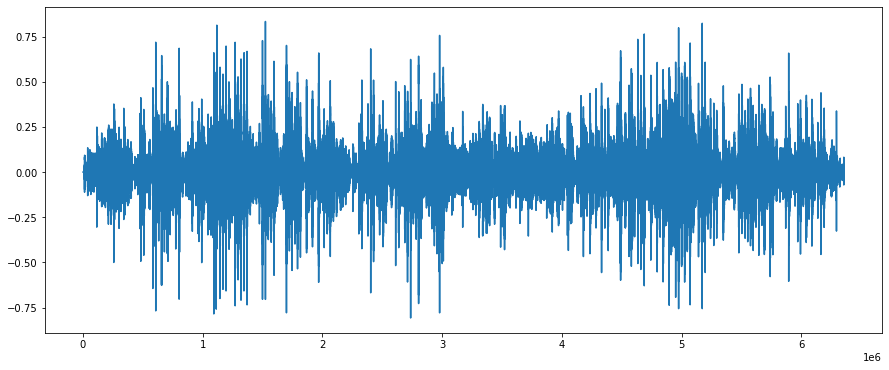

In [17]:
plt.figure(figsize=(15,6))
plt.plot(librosa_audio)

In [19]:
scipy_sample_rate, scipy_audio = wav.read(audio_path)

In [25]:
moon_df = pd.DataFrame(scipy_audio)

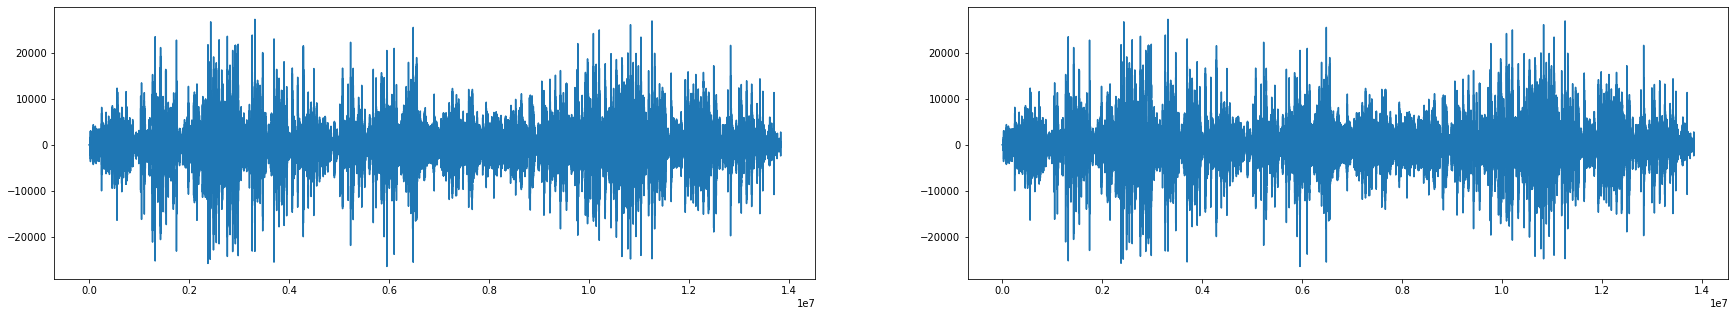

In [43]:
figure, axs = plt.subplots(1,2,figsize=(30,5))

axs[0].plot(moon_df.loc[:, 0])
axs[1].plot(moon_df.loc[:, 1])


In [199]:
files = os.listdir('audios')[1:]
n_files = len(files)
audios = []
freqs = []
classes = []
for i, file in enumerate(files):
    librosa_audio, librosa_sample_rate = librosa.load('audios/'+file)
    mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)
    
    y=librosa_audio
    sr = librosa_sample_rate
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    feats = [mfccs, chroma_stft, spec_cent, spec_bw, rolloff, zcr]
    new_feats = []
    for feat in feats:
        new_feats+=list(np.mean(feat, axis=1))
    
    audios.append(new_feats)
    freqs.append(librosa_audio)

    new_cls = ''
    if 'moto' in file:
        new_cls+='moto'
    elif 'onibus' in file:
        new_cls+='onibus'
    elif 'carro' in file:
        new_cls+='carro'    
    classes.append(new_cls)
        
    clear_output(wait=True)
    print('{}/{}'.format(i, n_files))

audio_df = pd.DataFrame(audios)
audio_df['target'] = classes

23/24


In [202]:
audio_df.shape

(24, 57)

In [204]:
freqs_df = pd.DataFrame(freqs)

freqs_df['target']=classes

In [205]:
audio_df['target'].value_counts()

carro     15
onibus     5
moto       4
Name: target, dtype: int64

In [206]:
classifiers = all_estimators('classifier')
log_reg = dict(classifiers)['LogisticRegression']
cr = metrics.classification_report

In [251]:
features = [col for col in audio_df.columns if col !='target']

In [252]:
x = audio_df[features]
y = audio_df['target']

In [274]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

[a.value_counts() for a in [y_train, y_test]]

[carro     14
 onibus     3
 moto       2
 Name: target, dtype: int64,
 moto      2
 onibus    2
 carro     1
 Name: target, dtype: int64]

In [275]:
model = log_reg().fit(x_train, y_train)
y_pred = model.predict(x_test)
labels = (y_test, y_pred)

print(cr(*labels))

              precision    recall  f1-score   support

       carro       1.00      1.00      1.00         1
        moto       0.33      0.50      0.40         2
      onibus       0.00      0.00      0.00         2

    accuracy                           0.40         5
   macro avg       0.44      0.50      0.47         5
weighted avg       0.33      0.40      0.36         5



C:\Users\luisr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [283]:
def build_model_graph(x, y):

    input_shape = (x.shape, )
    num_labels = len(y.unique())
    
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [284]:
model = build_model_graph(x, y)

In [285]:
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100


ValueError: in user code:

    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\luisr\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible
